In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
import time

Woodwork may not support Python 3.7 in next non-bugfix release.
Featuretools may not support Python 3.7 in next non-bugfix release.


# 1. Check datasetes

### 1.1 Read dataset

In [2]:
df_train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
df_test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')

In [3]:
print('df_train shape: ', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape:  (9557, 143)    df_test shape:  (23856, 142)


In [4]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


### 1.2 Make description df

In [6]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [7]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
...,...,...
136,SQBhogar_nin,hogar_nin squared
137,SQBovercrowding,overcrowding squared
138,SQBdependency,dependency squared
139,SQBmeaned,meaned squared


### 1.3 Check null data

In [8]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [9]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [10]:
missing_df

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
...,...,...
abastaguadentro,0,0.000000
cielorazo,0,0.000000
techootro,0,0.000000
techocane,0,0.000000


### 1.4 Fill missing values

In [11]:
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"]
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), 'escolari']

432     1
568     1
595     1
976     1
1574    1
2464    1
2614    1
3469    1
3855    1
3952    1
4197    1
4487    1
4867    1
4888    1
4920    1
6030    1
6067    1
6427    1
7117    1
7887    1
8134    1
8164    1
8437    1
8509    1
9166    1
Name: escolari, dtype: int64

In [12]:
# if education is "yes" and person is head of household, fill with escolari
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

#### rez_esc, SQBmeaned
- rez_esc : Years Behind in School -> filled with 0
- SQBmeaned : square of the mean years of education of adults (>=18) in the household agesq, Age squared -> same with rez_esc -> filled with 0

In [13]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

#### meaneduc
- meaneduc: average years of education for adults (18+) -> filled with 0

In [14]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

#### v18q1
- v18q1: number of tablets household owns -> if v18q(Do you own a tablet?) == 1, there are some values. If not, only NaN values in v18q1. See below 3 cells.

In [15]:
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [16]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [17]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [18]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

In [19]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

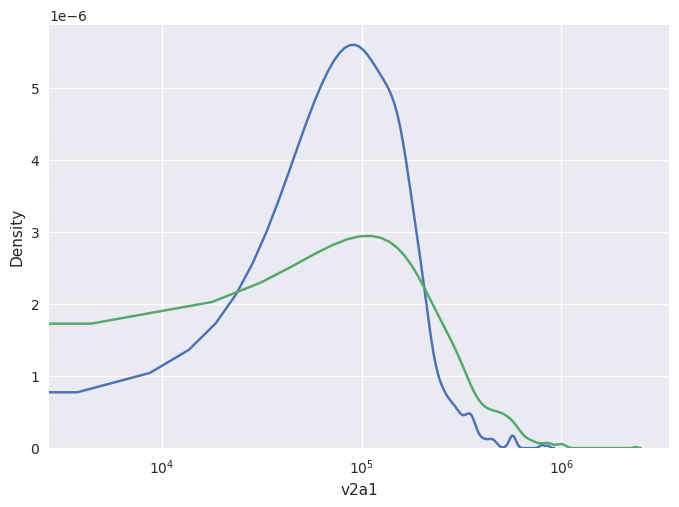

In [20]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'],
           label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'],
           label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [21]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [22]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
v2a1,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0


In [23]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)


,Total,Percent
edjef,23856,100.0
hogar_mayor,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_total,0,0.0
parentesco8,0,0.0


In [24]:
df_train

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,edjef
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,1849,1,100,0,1.000000,0.0000,100.0000,1849,4,NaN
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,4489,1,144,0,1.000000,64.0000,144.0000,4489,4,NaN
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,8464,1,0,0,0.250000,64.0000,121.0000,8464,4,NaN
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,289,16,121,4,1.777778,1.0000,121.0000,289,4,NaN
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,1369,16,121,4,1.777778,1.0000,121.0000,1369,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,0.0,0,...,2116,25,81,1,1.562500,0.0625,68.0625,2116,2,NaN
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,0.0,0,...,4,25,81,1,1.562500,0.0625,68.0625,4,2,NaN
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,0.0,0,...,2500,25,81,1,1.562500,0.0625,68.0625,2500,2,NaN
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,0.0,0,...,676,25,81,1,1.562500,0.0625,68.0625,676,2,NaN


### 2. Feature engineering

#### 2.1 Object features

In [25]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [26]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

**Q. feature이 객체형 ?? 무슨말이지**

In [27]:
df_train[[features_object[2]]]

,dependency
0,no
1,8
2,8
3,yes
4,yes
...,...
9552,.25
9553,.25
9554,.25
9555,.25


dependency

**Q. np.sqrt란?**

In [28]:
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

In [29]:
df_train['dependency']

0       0.00
1       8.00
2       8.00
3       1.00
4       1.00
        ... 
9552    0.25
9553    0.25
9554    0.25
9555    0.25
9556    0.25
Name: dependency, Length: 9557, dtype: float64

In [30]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

**Q. apply란?**

**edjefa**

- edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- replace yes -> 1 and no -> 0

In [31]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [32]:
# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa', 'edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa', 'edjefe']], axis=1)

#### roof and electricity

In [33]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0

def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0
    
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis=1)

### 2.2 Extract cat features

there are many binary category features

In [34]:
print(df_train[df_train.columns[0]].value_counts().shape[0])
print(df_train[df_train.columns[1]].value_counts().shape[0])
print(df_train[df_train.columns[2]].value_counts().shape[0])
print(df_train[df_train.columns[3]].value_counts().shape[0])

9557
157
2
11


category feature이 2개인 항목이 많나보다

In [35]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

In [36]:
binary_cat_features

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'v18q',
 'paredblolad',
 'paredzocalo',
 'paredpreb',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisomoscer',
 'pisocemento',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'cielorazo',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'public',
 'planpri',
 'noelec',
 'coopele',
 'sanitario1',
 'sanitario2',
 'sanitario3',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu6',
 'epared1',
 'epared2',
 'epared3',
 'etecho1',
 'etecho2',
 'etecho3',
 'eviv1',
 'eviv2',
 'eviv3',
 'dis',
 'male',
 'female',
 'estadocivil1',
 'estadocivil2',
 'estadocivil3',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'estadocivil7',
 'parentesco1',
 'parentesco2',
 'parentesco3',
 'parentesco4',
 'parentesco5',
 'parentesco6',
 'pa

### 2.3 Make new features using continuous feature

In [37]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

In [38]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [39]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
...,...,...
136,SQBhogar_nin,hogar_nin squared
137,SQBovercrowding,overcrowding squared
138,SQBdependency,dependency squared
139,SQBmeaned,meaned squared


In [40]:
print(f'There are {len(continuous_features)} continuous features')
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

There are 37 continuous features
v2a1: [' Monthly rent payment']
rooms: ['  number of all rooms in the house']
v18q1: [' number of tablets household owns']
r4h1: [' Males younger than 12 years of age']
r4h2: [' Males 12 years of age and older']
r4h3: [' Total males in the household']
r4m1: [' Females younger than 12 years of age']
r4m2: [' Females 12 years of age and older']
r4m3: [' Total females in the household']
r4t1: [' persons younger than 12 years of age']
r4t2: [' persons 12 years of age and older']
r4t3: [' Total persons in the household']
tamhog: [' size of the household']
tamviv: [' number of persons living in the household']
escolari: [' years of schooling']
rez_esc: [' Years behind in school']
hhsize: [' household size']
elimbasu5: [' =1 if rubbish disposal mainly by throwing in river,   creek or sea']
hogar_nin: [' Number of children 0 to 19 in household']
hogar_adul: [' Number of adults in household']
hogar_mayor: [' # of individuals 65+ in the household']
hogar_total: [

- hhsize: household size
- tamhog: size of household

Difference ?
- meaining of two features are same but the exact number are different.
- For now, I decided to drop one feature 'tamhog'

In [41]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [42]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)
# 2번 실행해버림

Squared features
- There are many squared features. Since I want to use lightgbm as feature filter model and set entity - embedding as classifier, I will keep them

Family features
- hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari
- Family size features (subtract, ratio)

In [43]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [44]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [45]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [46]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [47]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo']) / 2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo']) / 2

In [48]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1'] 

In [49]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [50]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

In [51]:
df_train['hogar_total']

0       1
1       1
2       1
3       4
4       4
       ..
9552    5
9553    5
9554    5
9555    5
9556    5
Name: hogar_total, Length: 9557, dtype: int64

In [52]:
df_train['r4t3']

0       1
1       1
2       1
3       4
4       4
       ..
9552    5
9553    5
9554    5
9555    5
9556    5
Name: r4t3, Length: 9557, dtype: int64

In [53]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

- 9557과 9509랑 숫자가 다르다는걸 보니, 'Total persons in the household'와 'total individuals in the household' is differnet

#### Rent per family features

- I will reduce the number of features using shap, so let's generate many features !! 

In [54]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

In [55]:
new_feats

['new_v2a1_per_adult',
 'new_v2a1_per_hogar_adul',
 'new_v2a1_per_hogar_mayor',
 'new_v2a1_per_hogar_nin',
 'new_v2a1_per_hogar_total',
 'new_v2a1_per_r4h1',
 'new_v2a1_per_r4h2',
 'new_v2a1_per_r4h3',
 'new_v2a1_per_r4m1',
 'new_v2a1_per_r4m2',
 'new_v2a1_per_r4m3',
 'new_v2a1_per_r4t1',
 'new_v2a1_per_r4t2',
 'new_v2a1_per_r4t3',
 'new_v2a1_per_hhsize']

- Ration feature can have infinite features. Fill with 0

In [56]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [57]:
df_train['new_v2a1_per_adult']

0       190000.0
1            0.0
2            0.0
3        90000.0
4        90000.0
          ...   
9552     20000.0
9553     20000.0
9554     20000.0
9555     20000.0
9556     20000.0
Name: new_v2a1_per_adult, Length: 9557, dtype: float64

#### BedRoom per family features

In [58]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_bedrooms_per_{}'.format(col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [59]:
print(df_train.shape, df_test.shape) # To check the same number of features between train and test (target is there in train)

(9557, 205) (23856, 204)


#### Tabulet per family features

In [60]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_v18q1_per_{}'.format(col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]
    
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

phone per family features

In [61]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_qmobilephone_per_{}'.format(col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

rez_esc(Years behind in school) per family features

In [62]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [63]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

prediction: the richer, the larger number of phones & tabulet

In [64]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

- wall, roof, floor may be key factor
- multiply

In [65]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [66]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [67]:
print(df_train.shape, df_test.shape)

(9557, 307) (23856, 306)


mix electricity and energy features -> energy features

In [68]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

mix toilet and rubbish disposal features -> other_infra features

In [69]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

mix toilet and water provision features -> water features

In [70]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [71]:
print(df_train.shape, df_test.shape)

(9557, 368) (23856, 367)


mix education and area features -> education_zone_features

In [72]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

- Mix region and education

In [73]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [74]:
print(df_train.shape, df_test.shape)

(9557, 440) (23856, 439)


#### Remove feature with only one value

In [75]:
cols_with_only_one_value = []
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6


- remove them!

In [76]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

#### Check whether both rain and test have same features

In [77]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [78]:
(cols_train == cols_test).sum() == len(cols_train)

True

#### 2.4 aggregation features

In [79]:
def max_min(x):
    return x.max() - x.min()

In [80]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean', 'std', 'min', 'max', 'sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 15/15 [00:15<00:00,  1.05s/it]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


In [81]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
              'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
              'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
              'parentesco11', 'parentesco12',
              'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
             'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
             'area1', 'area2', 'v18q', 'edjef']
for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 47/47 [00:01<00:00, 30.65it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [82]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 9/9 [00:10<00:00,  1.13s/it]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [83]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 625) test shape: (23856, 624)


In [84]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 907) test shape: (23856, 906)


In [85]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1189) test shape: (23856, 1188)


In [86]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|██████████| 7/7 [04:40<00:00, 40.07s/it]

train shape: (9557, 3163) test shape: (23856, 3162)


왜안되지 ??

In [87]:
train = train_agg.query('parentesco1==1')

**Q.query란 ??**

In [88]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [89]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [90]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3151) (23856, 3150)


In [91]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
edjef                                 0.333791
new5_lugar4_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min         0.333791
new5_lugar2_idhogar_edjef_min         0.333791
new5_lugar1_idhogar_edjef_min         0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
escolari                     

In [92]:
print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 negative feature: 
new5_lugar5_idhogar_television_<function max_min at 0x7ff650a12cb0>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x7ff650a12cb0>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x7ff650a12cb0>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x7ff650a12cb0>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x7ff650a12cb0>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x7ff650a12cb0>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x7ff650a12cb0>         NaN
new5_lugar6_idhogar_eviv2_<function max_min at 0x7ff650a12cb0>       

# 4. Feature selection using shap

In [93]:
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [94]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [95]:
y = train['Target']
train.drop(columns=['Target'], inplace=True)

In [96]:
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('*'*20, "Execution ended in {:0>2}h {:0>2}m {:05.2f}s".format(int(hours),int(minutes),seconds), '*'*20)

In [97]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb, categorical_feature=categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)

    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
#     feat_importance_df_shap['shap_cumsum'] = feat_importance_df_shap['shap_values'].cumsum() / feat_importance_df_shap['shap_values'].sum()
#     good_features = feat_importance_df_shap.loc[feat_importance_df_shap['shap_cumsum'] < 0.999].feature
    return feat_importance_df_shap

In [98]:
total_shap_df  = pd.DataFrame()
NUM_ITERATIONS = 50
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	training's multi_logloss: 1.11379	training's macroF1: 0.485107	valid_1's multi_logloss: 1.1027	valid_1's macroF1: 0.372485
******************** Execution ended in 00h 00m 38.14s ********************
============================== 2 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[500]	training's multi_logloss: 1.12813	training's macroF1: 0.488939	valid_1's multi_logloss: 1.10145	valid_1's macroF1: 0.378255
************